In [ ]:
# ..... clustering with Monocle3? ..... #

In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(monocle3)
library(mclust)

In [ ]:
# assign majority cell type label to cluster
get_cluster_label <- function(vec1, ctype1){
    cluster_list = unique(vec1)
    cluster_label = ctype1
    
    for(ii in 1:length(cluster_list)){
        ids = which(vec1==cluster_list[ii])
        cluster_label[ids] = names(which.max(table(ctype1[ids])))
    }
    
    return(cluster_label)
}

In [85]:
# get list of samples
stages = c(rep('stage23', 2), rep(c('stage28', 'stage32'), each = 3))
samples = c('sample3', 'sample10', 'sample5', 'sample10', 'sample11',
           'sample5', 'sample10', 'sample12')
qiu_stage = c('E9.5', 'E9.5', 'E10.5', 'E10.5', 'E10.5', 'E11.5', 'E11.5', 'E11.5')

In [86]:
# load data
pb = txtProgressBar(min = 0, max = length(stages), initial = 0)

for(id in 3:length(stages)){
    
    sc1 = readRDS(paste0(stages[id], '_', samples[id], '_data.rds'))
    sc1$dataset = paste0('s', sub('\\.*sample', '', samples[id]))

    # get expr data for monocle
    expression_matrix = GetAssayData(sc1, 'counts')
    gene_df = data.frame(gene_short_name = rownames(expression_matrix))
    rownames(gene_df) = rownames(expression_matrix)

    cds <- new_cell_data_set(expression_matrix,
                             cell_metadata = sc1@meta.data,
                             gene_metadata = gene_df)

    ## Step 1: Normalize and pre-process the data
    cds <- preprocess_cds(cds, num_dim = 100)
    
    ## Step 3: Reduce the dimensions using UMAP
    cds <- reduce_dimension(cds)

    ## Step 4: Cluster the cells
    cds <- cluster_cells(cds)
    
    
    ## get other cluster labels
    # load SHC clusters too
    load(paste0(stages[id], '_', samples[id], '_clusters_SHC.Rdata'))
    cds$shc_clusters = clusters[[1]]

    # get updated cluster list
    m1 = read.delim(paste0(stages[id], '_', samples[id], '_Qiu_', qiu_stage[id], '_celltypes.csv'), sep = ',')
    ids = match(m1$barcode, colnames(cds))
    m1$shc_cluster = cds$shc_clusters
    m1$monocle_cluster = cds@clusters@listData$UMAP$clusters
    # m1[1,]
    
    
    ## get majority cluster label
    m1$shc_label = get_cluster_label(m1$shc_cluster, m1$class)
    m1$monocle_label = get_cluster_label(m1$monocle_cluster, m1$class)
    print(adjustedRandIndex(m1$shc_label, m1$monocle_label))
    setTxtProgressBar(pb, id)

    # save
    write.table(m1, file = paste0(stages[id], '_', samples[id], '_Qiu_SHC_Monocle_clusters.csv'), sep = ',',
                row.names = F, col.names = T, quote = F)
}

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.7742934

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.8690741

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.5265931

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.5894485

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.7869122

No preprocess_method specified, using preprocess_method = 'PCA'



[1] 0.8637242

In [91]:
# make one file per stage
df = c()
for(id in 6:8){
    temp = read.delim(paste0(stages[id], '_', samples[id], '_Qiu_SHC_Monocle_clusters.csv'), sep = ',')
    temp$stage = stages[id]
    temp$sample = samples[id]
    df = rbind(df, temp)
}
write.table(df, file = paste0(stages[id], '_Qiu_SHC_Monocle_clusters.csv'), sep = ',',
                row.names = F, col.names = T, quote = F)

In [92]:
df[1,]

barcode                            class          celltype             
1 stage32_sample5_AAACCCACAAGGATGC-1 Cardiomyocytes Atrial cardiomyocytes
  final_celltype        shc_cluster monocle_cluster shc_label     
1 Atrial cardiomyocytes 1           1               Cardiomyocytes
  monocle_label  stage   sample 
1 Cardiomyocytes stage32 sample5

No trajectory to plot. Has learn_graph() been called yet?



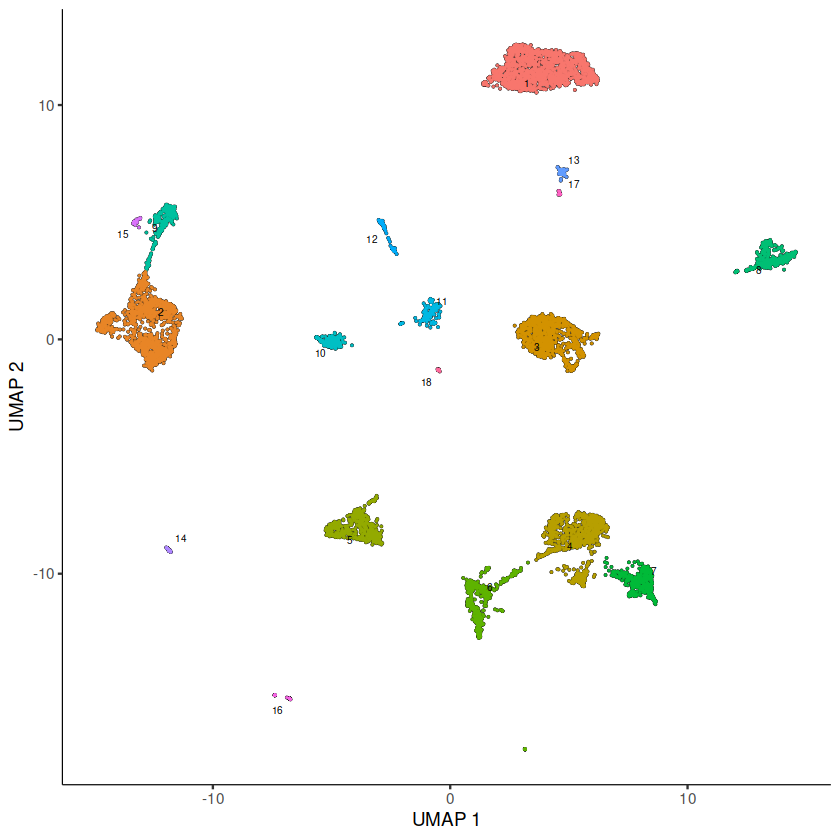

In [87]:
plot_cells(cds)

In [88]:
m1 %>% group_by(shc_cluster, shc_label) %>% summarise(count = n())
m1 %>% group_by(monocle_cluster, monocle_label) %>% summarise(count = n())

`summarise()` has grouped output by 'shc_cluster'. You can override using the `.groups`
argument.


shc_cluster shc_label             count
1   1          Primitive_erythroid    548 
2   2          Cardiomyocytes         393 
3   3          Cardiomyocytes         593 
4   4          Cardiomyocytes         317 
5   5          Cardiomyocytes         107 
6   6          Mesoderm               641 
7   7          Endothelium            423 
8   8          Mesoderm              1053 
9   9          Mesoderm               575 
10 10          Cardiomyocytes         152 
11 11          Cardiomyocytes         166 
12 12          Primitive_erythroid    137 
13 13          Mesoderm                31 
14 14          Primitive_erythroid    246 
15 15          Primitive_erythroid     28 
16 16          Primitive_erythroid     54 
17 17          Primitive_erythroid     34 
18 18          Primitive_erythroid    172 
19 19          Primitive_erythroid    390 
20 20          Mesoderm               393 
21 21          Mesoderm               852 
22 22          Primitive_erythroid     22 
23 23          Primitive_erythroid     23 
24 24          Mesoderm               151 
25 25          Mesoderm               364 
26 26          Mesoderm               234 
27 27          Neural_crest_PNS_glia  123 
28 28          CNS_neurons             79

`summarise()` has grouped output by 'monocle_cluster'. You can override using the `.groups`
argument.


monocle_cluster monocle_label         count
1  1               Primitive_erythroid   1663 
2  2               Cardiomyocytes        1376 
3  3               Mesoderm              1068 
4  4               Mesoderm               953 
5  5               Mesoderm               597 
6  6               Mesoderm               575 
7  7               Mesoderm               439 
8  8               Endothelium            438 
9  9               Cardiomyocytes         319 
10 10              Mesoderm               246 
11 11              Cardiomyocytes         227 
12 12              Neural_crest_PNS_glia  126 
13 13              Megakaryocytes         104 
14 14              CNS_neurons             56 
15 15              Cardiomyocytes          33 
16 16              CNS_neurons             30 
17 17              White_blood_cells       29 
18 18              Mesoderm                22

In [113]:
# plot summaries
id = 2
df = read.delim(paste0(stages[id], '_', samples[id], '_Qiu_SHC_Monocle_clusters.csv'), sep = ',')

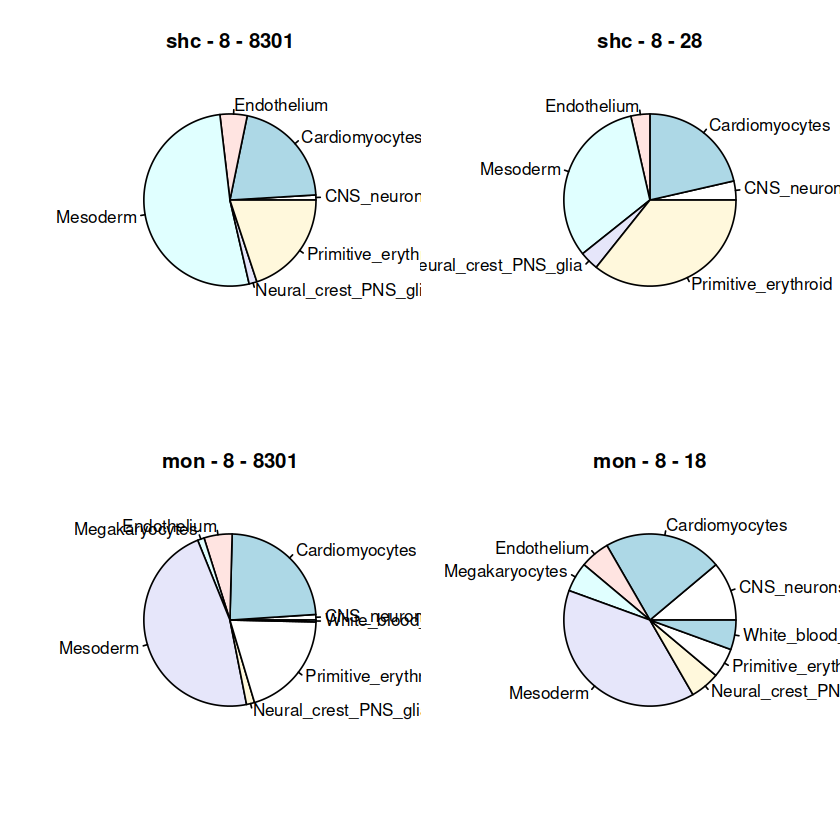

In [109]:
newdf1 = data.frame(df %>% group_by(shc_label) %>% summarise(count = n()))
newdf2 = data.frame(df %>% group_by(shc_label) %>% summarise(count = length(unique(shc_cluster))))
newdf3 = data.frame(df %>% group_by(monocle_label) %>% summarise(count = n()))
newdf4 = data.frame(df %>% group_by(monocle_label) %>% summarise(count = length(unique(monocle_cluster))))

# pdf(paste0('aa-', id, '-pies-shc-mon.pdf'), width = 8, height = 8)
par(mfrow = c(2,2))
pie(newdf1$count, labels = newdf1$shc_label, main = paste0('shc - ', id, ' - ', dim(df)[1])) 
pie(newdf2$count, labels = newdf2$shc_label, main = paste0('shc - ', id, ' - ', length(unique(df$shc_cluster))))
pie(newdf3$count, labels = newdf3$monocle_label, main = paste0('mon - ', id, ' - ', dim(df)[1]))
pie(newdf4$count, labels = newdf4$monocle_label, main = paste0('mon - ', id, ' - ', length(unique(df$monocle_cluster))))
# dev.off()